# Dfs0

In [1]:
import numpy as np
import pandas as pd

## Reading data

In [2]:
from mikeio import Dfs0

dfs = Dfs0("data/TemporalEqTime.dfs0")
dfs

<mikeio.Dfs0>
Timeaxis: TimeAxisType.TimeEquidistant
Items:
  0:  WaterLevel item <Water Level> (meter)
  1:  WaterDepth item <Water Depth> (meter)

In [3]:
ds = dfs.read()
ds

<mikeio.DataSet>
Dimensions: (10,)
Time: 1970-01-01 00:00:00 - 1970-01-01 00:01:30
Items:
  0:  WaterLevel item <Water Level> (meter)
  1:  WaterDepth item <Water Depth> (meter)

In [4]:
type(ds)

mikeio.dataset.Dataset

The MIKE IO `Dataset` are used by all Dfs classes (Dfs0,Dfs1,Dfs2,Dfs3, Dfsu) but Dfs0 data are best handled by a Pandas DataFrame.

In [5]:
df = ds.to_dataframe() # convert dataset to dataframe
df

,WaterLevel item,WaterDepth item
1970-01-01 00:00:00,0.0,100.0
1970-01-01 00:00:10,1.0,101.0
1970-01-01 00:00:20,2.0,102.0
1970-01-01 00:00:30,3.0,103.0
1970-01-01 00:00:40,4.0,104.0
1970-01-01 00:00:50,5.0,105.0
1970-01-01 00:01:00,10.0,110.0
1970-01-01 00:01:10,11.0,111.0
1970-01-01 00:01:20,12.0,112.0
1970-01-01 00:01:30,13.0,113.0


In [6]:
df2 = dfs.to_dataframe() # or read as a data frame directly
df2

,WaterLevel item,WaterDepth item
1970-01-01 00:00:00,0.0,100.0
1970-01-01 00:00:10,1.0,101.0
1970-01-01 00:00:20,2.0,102.0
1970-01-01 00:00:30,3.0,103.0
1970-01-01 00:00:40,4.0,104.0
1970-01-01 00:00:50,5.0,105.0
1970-01-01 00:01:00,10.0,110.0
1970-01-01 00:01:10,11.0,111.0
1970-01-01 00:01:20,12.0,112.0
1970-01-01 00:01:30,13.0,113.0


In [7]:
all(df == df2)

True

## Writing data

[NASA - Global temperature](https://climate.nasa.gov/vital-signs/global-temperature/)

In [28]:
df = pd.read_csv("data/naples_fl.csv", skiprows=1, parse_dates=True, index_col=0)
df

,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
Date,,,,,,
2002-03-01,67.0,78.0,56.0,0.00,NaN,NaN
2002-03-02,76.0,83.0,69.0,0.00,NaN,NaN
2002-03-03,78.0,84.0,71.0,0.00,NaN,NaN
2002-03-04,64.0,76.0,51.0,0.08,NaN,NaN
2002-03-05,58.0,70.0,45.0,0.00,NaN,NaN
...,...,...,...,...,...,...
2021-08-11,NaN,93.0,77.0,0.23,NaN,NaN
2021-08-12,NaN,94.0,77.0,0.00,0.0,0.0
2021-08-13,NaN,95.0,77.0,0.03,0.0,0.0


You will probably have the need to parse certain a specific data formats many times, then it is a good idea to create a function.

In [77]:
def read_ncei_obs(filename):
    """Parse Meteo observations from NCEI"""
    
    sel_cols = ['temperature_avg_f','temperature_max_f','temperature_min_f', 'prec_in']
    df = (
        pd.read_csv("data/naples_fl.csv", skiprows=1, parse_dates=True, index_col=0)
           .rename(columns={'TAVG (Degrees Fahrenheit)': 'temperature_avg_f',
                            'TMAX (Degrees Fahrenheit)': 'temperature_max_f',
                            'TMIN (Degrees Fahrenheit)': 'temperature_min_f',
                            'PRCP (Inches)': 'prec_in'})
    )[sel_cols]
    
    df.index = pd.DatetimeIndex(df.index, freq='infer') # detect equidistant
    
    return df

In [79]:
df = read_ncei_obs("data/naples_fl.csv")
df.head()

,temperature_avg_f,temperature_max_f,temperature_min_f,prec_in
Date,,,,
2002-03-01,67.0,78.0,56.0,0.00
2002-03-02,76.0,83.0,69.0,0.00
2002-03-03,78.0,84.0,71.0,0.00
2002-03-04,64.0,76.0,51.0,0.08
2002-03-05,58.0,70.0,45.0,0.00


In [80]:
df.tail()

,temperature_avg_f,temperature_max_f,temperature_min_f,prec_in
Date,,,,
2021-08-11,NaN,93.0,77.0,0.23
2021-08-12,NaN,94.0,77.0,0.00
2021-08-13,NaN,95.0,77.0,0.03
2021-08-14,NaN,85.0,74.0,0.05
2021-08-15,NaN,83.0,75.0,0.01


In [81]:
df.shape

(7108, 4)

In [82]:
df['temperature_max_c'] = (df['temperature_max_f'] - 32)/1.8
df['prec_mm'] = df['prec_in'] * 25.4
df.head()

,temperature_avg_f,temperature_max_f,temperature_min_f,prec_in,temperature_max_c,prec_mm
Date,,,,,,
2002-03-01,67.0,78.0,56.0,0.00,25.555556,0.000
2002-03-02,76.0,83.0,69.0,0.00,28.333333,0.000
2002-03-03,78.0,84.0,71.0,0.00,28.888889,0.000
2002-03-04,64.0,76.0,51.0,0.08,24.444444,2.032
2002-03-05,58.0,70.0,45.0,0.00,21.111111,0.000


<AxesSubplot:xlabel='Date'>

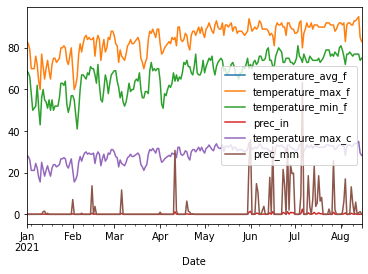

In [83]:
df.loc['2021'].plot()

The simplest way to create a dfs0 file is to use the `to_dfs0` method on a Pandas dataframe.

In [84]:
df.to_dfs0("output/naples_fl.dfs0")

Let's read it back in again...

In [85]:
saved_dfs0 = Dfs0("output/naples_fl.dfs0")
saved_dfs0

<mikeio.Dfs0>
Timeaxis: TimeAxisType.CalendarEquidistant
Items:
  0:  temperature_avg_f <Undefined> (undefined)
  1:  temperature_max_f <Undefined> (undefined)
  2:  temperature_min_f <Undefined> (undefined)
  3:  prec_in <Undefined> (undefined)
  4:  temperature_max_c <Undefined> (undefined)
  5:  prec_mm <Undefined> (undefined)

By default, EUM types are undefined. But it can be specified.

In [86]:
from mikeio.eum import EUMType

df['temperature_max_c'].to_dfs0("output/naples_fl_eum.dfs0", itemtype=EUMType.Temperature)

In [87]:
Dfs0("output/naples_fl_eum.dfs0")

<mikeio.Dfs0>
Timeaxis: TimeAxisType.CalendarEquidistant
Items:
  0:  temperature_max_c <Temperature> (degree Celsius)

## EUM

In [14]:
from mikeio.eum import ItemInfo, EUMType, EUMUnit

EUMType.search("wind")


[Wind Velocity,
 Wind Direction,
 Wind friction factor,
 Wind speed,
 Depth of Wind,
 Wind friction speed]

In [15]:
EUMType.Wind_speed.units

[meter per sec, feet per sec, knot, km per hour, miles per hour]

## Precipitation data

In [16]:
df = pd.read_csv("data/precipitation.csv", parse_dates=True, index_col=0)
df.head()

,Precipitation station 1,Precipitation station 2,Precipitation station 3,Precipitation station 4,Precipitation station 5,Precipitation station 6,Precipitation station 7,Precipitation station 8,Precipitation station 9
date,,,,,,,,,
2001-01-01,0.0,0.000,0.021,0.071,0.000,0.000,0.025,0.025,0.000
2001-01-02,0.0,0.025,0.037,0.000,0.004,0.054,0.042,0.021,0.054
2001-01-03,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.042,0.000
2001-01-04,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2001-01-05,0.0,0.000,0.158,0.021,0.000,0.000,0.017,0.021,0.000


In [17]:
from mikecore.DfsFile import DataValueType

items = [ItemInfo(name, EUMType.Precipitation_Rate, EUMUnit.mm_per_hour, data_value_type=DataValueType.MeanStepBackward) for name in df.columns]

items

[Precipitation station 1 <Precipitation Rate> (mm per hour),
 Precipitation station 2 <Precipitation Rate> (mm per hour),
 Precipitation station 3 <Precipitation Rate> (mm per hour),
 Precipitation station 4 <Precipitation Rate> (mm per hour),
 Precipitation station 5 <Precipitation Rate> (mm per hour),
 Precipitation station 6 <Precipitation Rate> (mm per hour),
 Precipitation station 7 <Precipitation Rate> (mm per hour),
 Precipitation station 8 <Precipitation Rate> (mm per hour),
 Precipitation station 9 <Precipitation Rate> (mm per hour)]

In [18]:
items[0].data_value_type

<DataValueType.MeanStepBackward: 3>

In [19]:
df.to_dfs0("output/precipitation.dfs0",items=items)

## Selecting items

In [20]:
dfs = Dfs0("output/precipitation.dfs0")
ds = dfs.read(items=[1,4]) # select item by item number (starting from zero)
ds

<mikeio.DataSet>
Dimensions: (31,)
Time: 2001-01-01 00:00:00 - 2001-01-31 00:00:00
Items:
  0:  Precipitation station 2 <Precipitation Rate> (mm per hour)
  1:  Precipitation station 5 <Precipitation Rate> (mm per hour)

In [21]:
ds = dfs.read(items=["Precipitation station 6","Precipitation station 3"]) # or by name (in the order you like it)
ds

<mikeio.DataSet>
Dimensions: (31,)
Time: 2001-01-01 00:00:00 - 2001-01-31 00:00:00
Items:
  0:  Precipitation station 6 <Precipitation Rate> (mm per hour)
  1:  Precipitation station 3 <Precipitation Rate> (mm per hour)

In [22]:
items = list(reversed(range(1,8,2))) # not sure if this is useful, but it is possible ;-)
items

[7, 5, 3, 1]

In [23]:
ds = dfs.read(items=items)
ds

<mikeio.DataSet>
Dimensions: (31,)
Time: 2001-01-01 00:00:00 - 2001-01-31 00:00:00
Items:
  0:  Precipitation station 8 <Precipitation Rate> (mm per hour)
  1:  Precipitation station 6 <Precipitation Rate> (mm per hour)
  2:  Precipitation station 4 <Precipitation Rate> (mm per hour)
  3:  Precipitation station 2 <Precipitation Rate> (mm per hour)

Note that once you have read data into a Dataset, the item number no longer reflects the item number in the file!